In [1]:
import sys
sys.path.append('/home/iganesh/pvert')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
import pandas as pd
import geopandas as gpd
import fiona

import cmcrameri.cm as cmc

from FresnelCoefficients import FresnelV, FresnelH
# import RFE_model_fitting as RFE

In [2]:
### Regression function: Venus altitude vs temperature from 

def pradius2T(pradius):
    return (pradius - 6139.5 ) / -0.1192

def T2pradius(T):
    return (-0.1192 * T) + 6139.5

def curieweiss(Tc, T, C):
    ### Curie-Weiss equation
    eps = np.zeros_like(T)
    eps[T>Tc] = C / (T[T>Tc] - Tc) #**.7
    epsmax = np.nanmin(eps)
    eps[T<=Tc] = epsmax
    return eps

def RFE_santos_eiras(T, T_max, eps_max, delta, gamma=2):
    ### equation for relaxor ferroelectrics - Santos and Eiras
    eps = np.zeros_like(T)
    eps = eps_max / (1 + np.abs(np.power((T - T_max).astype(np.complex)/delta,gamma)))
    return eps


### Equations for emissivity and reflectivity:

def eps2ref(eps):
    rh, th, Rh, Th = FresnelH(1, eps, np.deg2rad(35))
    return Rh
    
def eps2emis(eps):
    rh, th, Rh, Th = FresnelH(1, eps, np.deg2rad(35))
    return 1 - Rh

### dielectric mixing
def effective_permittivy_sphere(eps_eff, eps, eps_inc, f, N):
    # eps_eff = eps + ((3 * f * (eps_inc - eps) * eps_eff) / (3 * eps_eff + (eps_inc - eps_eff)* (1-f)))
    eps_eff_final = 0
    sum_term = 0
    
    for i in N:
        sum_term =  eps_eff / (eps_eff + i * (eps_inc - eps_eff)) 
        
    eps_eff = eps + ((f/3) * (eps_inc - eps) *  sum_term)
    return eps_eff

## get volume of ferroelectrics
def volume_FE(eps_inc, eps_eff = 65, eps_bg = 3.5, N = [1/2, 1/2, 0]):
    sum_term = 0
    for i in N:
        sum_term =  eps_eff / (eps_eff + i * (eps_inc - eps_eff)) 
        
    f = 3 * (eps_eff - eps_bg) / (eps_inc - eps_bg) / sum_term
    return f

# return geodataframe from file
def get_df(file, unit, emissivity_field = "SURFACE_EMISSIVITY", topo_field = "AVERAGE_PLANETARY_RADIUS"):
    data = gpd.read_file(file, layer=unit)
    data = data[data[emissivity_field]<1]
    return data

### <b> PLOT BEST-FIT FE AND RFE MODELS ALONG WITH DATA </b>

In [3]:
file = ("/mnt/c/Users/iganesh/Work/Research/Venus/ImpactDeposits/Datasets/Ovda/Final/gpkg_units/arcdr_rdf_ovda_cycle1_Mar29_topoemis_hilosig2_n50_overlap05deg_n1deg_units_brushed_separate.gpkg")
allunits = fiona.listlayers(file)
units = ["Festoon flow", "3-a"]
colors = ["#ee8026", "#f4a736"]

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"


emissivity_field = "SURFACE_EMISSIVITY"
topo_field = "AVERAGE_PLANETARY_RADIUS"

In [4]:
# best fit RFE parameters for festoon flow and 3-a
RFE_eps_max = [1e5, 1e5]
delta = [7,6]
gamma = [1.8, 1.8]
RFE_conc = [0.0015, 0.001]
RFE_Tm = [703.7717, 703.5881]

# best fit FE parameters for festoon flow and 3-a
FE_C = [1e5, 1e5]
FE_Tc = [702.2717, 700.0881]
FE_conc = [0.005, 0.005]

In [5]:
emisH = []
emisH_fe = []
e_range = []
temp_range = []

for i in range(2):
    data = get_df(file, units[i], emissivity_field, topo_field)

    emis_min_row = data.loc[data[emissivity_field] == data[emissivity_field].min()]
    # elev_range = np.arange(data[topo_field].min(), data[topo_field].max(), 1e-4)
    elev_range = np.arange(6052.5, data[topo_field].max(), 1e-4)
    e_range.append(elev_range)
    T_range = pradius2T(elev_range)
    temp_range.append(T_range)
    T_m = pradius2T(emis_min_row[topo_field].values[0])
    eps_bg = 5
    N = [1/2, 1/2, 0]

    ## RFE fitting metrics
    # T_m = 704.5956

    eps_max = RFE_eps_max[i]
    delta = 8
    gamma = 1.8
    f = RFE_conc[i]
    T_m = RFE_Tm[i]
    #T_m = 704.09

    eps_inc_rfe = RFE_santos_eiras(T_range, T_m, eps_max, delta, gamma)

    eps_eff_initial = 65
    eps_eff_final = np.zeros_like(eps_inc_rfe)
    for k in range(len(eps_inc_rfe)):
        eps_eff_initial = 65
        while True:
            eps_eff = effective_permittivy_sphere(eps_eff_initial, eps_bg, eps_inc_rfe[k], f, N)
            temp = eps_eff_initial
            eps_eff_initial = eps_eff
            if (abs(temp - eps_eff_initial) <= 0.001):
                eps_eff_final[k] = eps_eff
                break

    # emisH = eps2emis(eps_eff_final)
    emisH.append(eps2emis(eps_eff_final))


    ## FE fitting
    C = FE_C[i]
    T_m = FE_Tc[i]
    f = FE_conc[i]


    eps_inc_fe = curieweiss(T_m, T_range, C)
    eps_eff_final_fe = np.zeros(len(eps_inc_fe), dtype=float)


    for k in range(len(eps_inc_fe)):
        eps_eff_initial = 65
        while True:
            eps_eff = effective_permittivy_sphere(eps_eff_initial, eps_bg, eps_inc_fe[k], f, N)
            temp = eps_eff_initial
            eps_eff_initial = eps_eff
            if (abs(temp - eps_eff_initial) <= 0.001):
                eps_eff_final_fe[k] = eps_eff
                break

    # emisH_fe= eps2emis(eps_eff_final_fe)
    emisH_fe.append(eps2emis(eps_eff_final_fe))

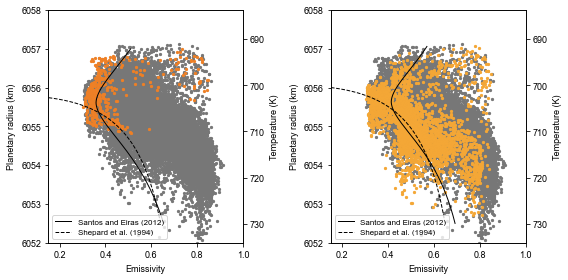

In [6]:
fig, ax = plt.subplots(1, 2, sharex=True)
# ax2 = ax.twinx()
fig.set_size_inches(8, 4)


for layername in allunits:
    data = gpd.read_file(file, layer=layername)
    if layername != "Festoon flow":
        ax[0].scatter(data[emissivity_field], data[topo_field], marker = 'o', color="#777777", s=5)
    if layername != "3-a":
        ax[1].scatter(data[emissivity_field], data[topo_field], marker = 'o', color="#777777", s=5)
        
for i in range(2):
    data = gpd.read_file(file, layer=units[i])
    data = data[data[emissivity_field]<1]
    ax[i].scatter(data[emissivity_field], data[topo_field], marker = 'o', s=5, color = colors[i])
    ax[i].plot(emisH[i], e_range[i], color = "k", linewidth = 1, label = "Santos and Eiras (2012)")
    ax[i].plot(emisH_fe[i][temp_range[i] > FE_Tc[i]], e_range[i][temp_range[i] > FE_Tc[i]], color = "k", linewidth = 1, linestyle = "--", label = "Shepard et al. (1994)")
    # 
    ax[i].set_xlim(0.15, 1.0)
    ax[i].set_ylim(6052, 6058)

    ax[i].set_xlabel("Emissivity", fontsize = 9)
    ax[i].set_ylabel("Planetary radius (km)", fontsize = 9)
    
    ax[i].tick_params(axis="both", which="major", labelsize=9)
    ax[i].legend(fontsize = 8, loc = "lower left")
    ax[i].xaxis.labelpad = 5
    ax[i].yaxis.labelpad = 5

    ## secondary y axis
    ax2 = ax[i].twinx()
    ax2.set_ylabel("Temperature (K)", fontsize = 9)
    ymin, ymax = ax[i].get_ylim()
    ax2.set_ylim(pradius2T(ymin),pradius2T(ymax))
    ax2.tick_params(axis="both", which="major", labelsize=9)
    ax2.yaxis.labelpad = 5
    
# ax[1].set_xlabel("Emissivity", fontsize = 9)
fig.tight_layout()
# plt.savefig("Fig9.pdf", bbox_inches='tight')
plt.show()